In [1]:
import os
import random
import shutil
import hashlib
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_recall_curve, roc_curve, auc, precision_score, recall_score, roc_auc_score, accuracy_score
from PIL import Image
from tensorflow.keras.losses import categorical_crossentropy
import pandas as pd


In [2]:
def preprocess_data():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    return train_datagen, val_test_datagen

def load_datasets(train_datagen, val_test_datagen, batch_size=64, target_size=(224, 224)):
    train_dir = "dataset\splited_dataset/train" 
    val_dir = "dataset\splited_dataset/validation"
    test_dir = "dataset\splited_dataset/test"

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
    )

    validation_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb'
    )

    return train_generator, validation_generator, test_generator

train_datagen, val_test_datagen = preprocess_data()
train_generator, validation_generator, test_generator = load_datasets(train_datagen, val_test_datagen)
class_names = list(train_generator.class_indices.keys())
class_count = len(class_names)
print("Number of classes:", class_count)
print(class_names)


Found 8031 images belonging to 2 classes.
Found 1003 images belonging to 2 classes.
Found 1006 images belonging to 2 classes.
Number of classes: 2
['benign', 'malignant']


In [3]:
all_classes_name = ['benign', 'malignant']

In [4]:
def depthwise_separable_resnet_block(input_tensor, filters, kernel_size=3, stride=1,conv_shortcut=False):
    
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.DepthwiseConv2D(kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    if conv_shortcut or stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same")(input_tensor)
        shortcut = layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

def squeeze_excitation_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation='relu', kernel_regularizer=l2(0.01), use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_regularizer=l2(0.01), use_bias=False)(se)

    x = layers.multiply([input_tensor, se])
    return x


def inception_with_SE_block(input_tensor, filters, l2_rate):

    conv1x1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)

    conv3x3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)

    conv5x5_1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(input_tensor)
    conv5x5_2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(conv5x5_1)
    conv5x5_3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(conv5x5_2)

    pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    pool_conv = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_rate))(pool)

    outputs = layers.concatenate([conv1x1, conv3x3, conv5x5_3, pool_conv], axis=-1)
    output_with_se = squeeze_excitation_block(outputs)
    return output_with_se

def spatial_attention_block(input_tensor):
    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    max_pool = layers.GlobalMaxPooling2D()(input_tensor)
    
    avg_pool = layers.Reshape((1, 1, input_tensor.shape[-1]))(avg_pool)
    max_pool = layers.Reshape((1, 1, input_tensor.shape[-1]))(max_pool)
    
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    output_tensor = layers.Multiply()([input_tensor, attention])
    return output_tensor

def Franklin_ensemble_model_1(input_shape, num_classes, l2_rate):
    inputs = layers.Input(shape=input_shape)

    x = depthwise_separable_resnet_block(inputs, filters=64)
    x = spatial_attention_block(x) 
    x = depthwise_separable_resnet_block(x, filters=32)


    x = layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = spatial_attention_block(x) 

    x = inception_with_SE_block(x, 32, l2_rate)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x) 
    x = spatial_attention_block(x) 
    
    x = inception_with_SE_block(x, 32, l2_rate)
    x = spatial_attention_block(x)  
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    Franklin_ensemble_model_1 = models.Model(inputs=inputs, outputs=outputs)
    return Franklin_ensemble_model_1


input_1 InputLayer
conv2d Conv2D
batch_normalization BatchNormalization
re_lu ReLU
conv2d_1 Conv2D
batch_normalization_1 BatchNormalization
re_lu_1 ReLU
depthwise_conv2d DepthwiseConv2D
batch_normalization_2 BatchNormalization
conv2d_2 Conv2D
re_lu_2 ReLU
batch_normalization_3 BatchNormalization
add Add
re_lu_3 ReLU
global_average_pooling2d GlobalAveragePooling2D
global_max_pooling2d GlobalMaxPooling2D
reshape Reshape
reshape_1 Reshape
concatenate Concatenate
conv2d_3 Conv2D
multiply Multiply
conv2d_4 Conv2D
batch_normalization_4 BatchNormalization
re_lu_4 ReLU
conv2d_5 Conv2D
batch_normalization_5 BatchNormalization
re_lu_5 ReLU
depthwise_conv2d_1 DepthwiseConv2D
batch_normalization_6 BatchNormalization
conv2d_6 Conv2D
re_lu_6 ReLU
batch_normalization_7 BatchNormalization
add_1 Add
re_lu_7 ReLU
conv2d_7 Conv2D
max_pooling2d MaxPooling2D
global_average_pooling2d_1 GlobalAveragePooling2D
global_max_pooling2d_1 GlobalMaxPooling2D
reshape_2 Reshape
reshape_3 Reshape
concatenate_1 Concaten

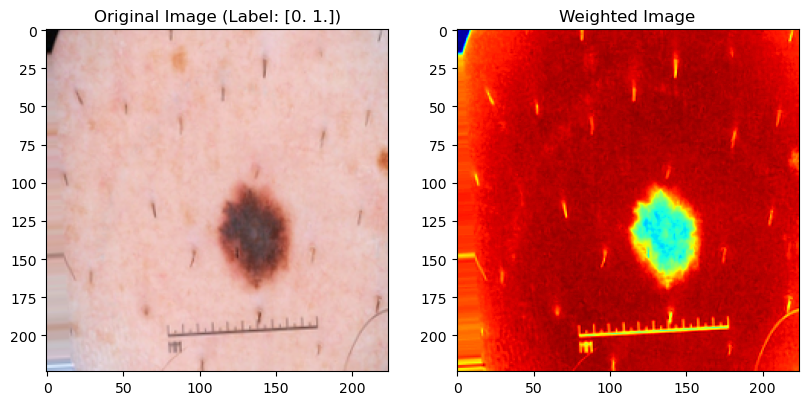

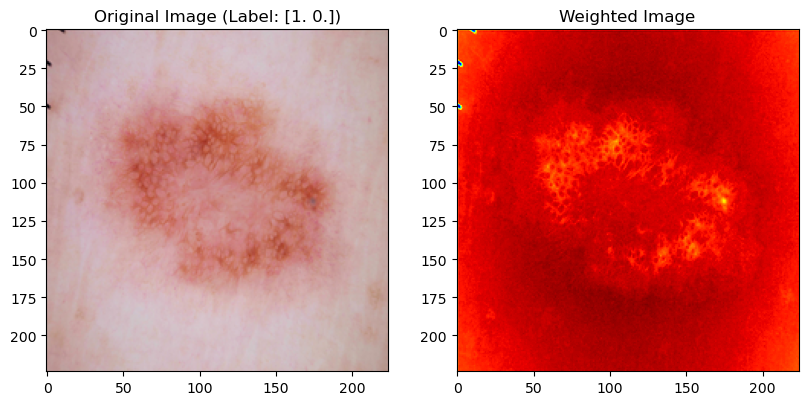

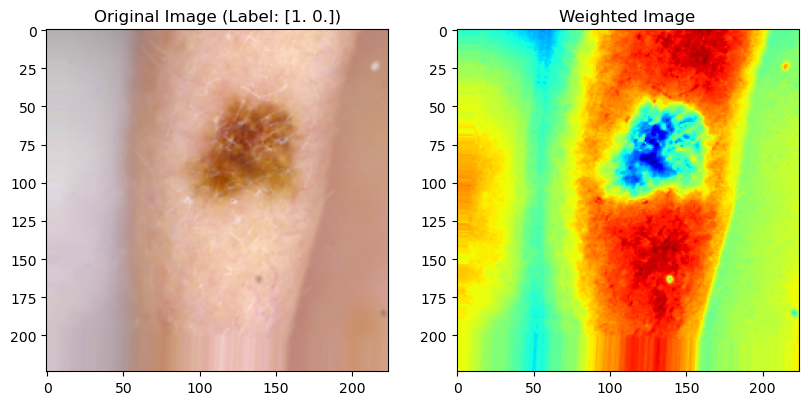

In [5]:
def attention_visualization_model(input_shape, num_classes, l2_rate):
    inputs = layers.Input(shape=input_shape)

    x = depthwise_separable_resnet_block(inputs, filters=64)
    x = spatial_attention_block(x) 
    x = depthwise_separable_resnet_block(x, filters=32)


    x = layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = spatial_attention_block(x) 

    x = inception_with_SE_block(x, 32, l2_rate)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x) 
    x = spatial_attention_block(x) 
    
    x = inception_with_SE_block(x, 32, l2_rate)
    x = spatial_attention_block(x)  
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    attention_visualization_model = models.Model(inputs=inputs, outputs=outputs)
    return attention_visualization_model

def generate_grad_cam(model, img_array, target_layer, output_layer):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(target_layer).output, model.get_layer(output_layer).output]
    )

    with tf.GradientTape() as tape:
        conv_output, model_output = grad_model(img_array)
        loss = tf.reduce_max(model_output, axis=1)
    grads = tape.gradient(loss, conv_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap
input_shape = (224, 224, 3)
model = attention_visualization_model(input_shape, num_classes=2, l2_rate=0.0001)
for layer in model.layers:
    print(layer.name, layer.__class__.__name__)


def find_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No convolutional layers found in the model.")

last_conv_layer_name = find_last_conv_layer_name(model)
# print(last_conv_layer_name)

output_layer_name = model.output.name.split("/")[0]

num_images = 3 

for i in range(num_images):
    batch = next(test_generator)

    img_array = batch[0]
    label = batch[1]

    heatmap1 = generate_grad_cam(model, img_array, last_conv_layer_name, output_layer_name)


    target_size = heatmap1.shape[0], heatmap1.shape[1]
    heatmap1_resized = tf.image.resize(heatmap1[..., np.newaxis], target_size)[..., 0]

    heatmap = heatmap1_resized 

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (input_shape[0], input_shape[1]))[..., 0]
    heatmap_expanded = tf.stack([heatmap_resized, heatmap_resized, heatmap_resized], axis=-1)


    weighted_img = heatmap_expanded * img_array[0]
    weighted_img /= np.max(weighted_img) if np.max(weighted_img) != 0 else 1


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_array[0])
    plt.title(f'Original Image (Label: {label[0]})')

    plt.subplot(1, 3, 2)
    plt.imshow(weighted_img[..., 0],cmap='jet')
    plt.title('Weighted Image')

    plt.show()


In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min')

Franklin_ensemble_model_1 = Franklin_ensemble_model_1((224, 224, 3), num_classes=class_count, l2_rate=0.01)
Franklin_ensemble_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss=categorical_crossentropy,
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)
Franklin_ensemble_model_1.summary()
print(Franklin_ensemble_model_1.optimizer) 
print(Franklin_ensemble_model_1.loss)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 224, 224, 64  256        ['conv2d_23[0][0]']              
 rmalization)                   )                                                           

In [7]:
import os

# 定义主文件夹路径
main_folder = "modelPerformanceGrace3"

# 创建主文件夹（如果不存在）
if not os.path.exists(main_folder):
    os.makedirs(main_folder)

# 定义模型文件路径
model_filename = "Franklin_ensemble_model_1.h5"
model_path = os.path.join(main_folder, model_filename)

# 保存模型文件
Franklin_ensemble_model_1.save(model_path)

# 创建checkpoint文件夹路径
checkpoint_folder = os.path.join(main_folder, "checkpoints")

# 创建checkpoint文件夹（如果不存在）
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)

# 定义checkpoint文件路径
checkpoint_filename = "model_checkpoint1.h5"
checkpoint_path = os.path.join(checkpoint_folder, checkpoint_filename)

# 保存最佳模型 checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                    save_best_only=True, 
                                                    monitor='val_loss', 
                                                    mode='min')

# 创建日志文件夹路径
log_folder = os.path.join(main_folder, "logs")

# 创建日志文件夹（如果不存在）
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# 定义日志文件路径
log_filename = "training1.log"
log_path = os.path.join(log_folder, log_filename)

# 创建 CSVLogger 回调来记录损失和准确率
csv_logger = tf.keras.callbacks.CSVLogger(log_path)

# 创建历史数据文件夹路径
history_folder = os.path.join(main_folder, "history_data1")

# 创建历史数据文件夹（如果不存在）
if not os.path.exists(history_folder):
    os.makedirs(history_folder)

# 定义历史数据文件路径
history_filename = "training_history1.csv"
history_path = os.path.join(history_folder, history_filename)

# 训练模型并保存历史数据
history1 = Franklin_ensemble_model_1.fit(train_generator, epochs=50, 
                                         validation_data=validation_generator,
                                         callbacks=[early_stopping, lr_reduction, model_checkpoint, csv_logger])

# 保存历史数据
history_df = pd.DataFrame(history1.history)
history_df.to_csv(history_path, index=False)


Epoch 1/50
126/126 [==============================] - 73s 563ms/step - loss: 2.3709 - accuracy: 0.8054 - precision: 0.8054 - recall: 0.8054 - val_loss: 1.2471 - val_accuracy: 0.4985 - val_precision: 0.4985 - val_recall: 0.4985 - lr: 0.0010
Epoch 2/50
126/126 [==============================] - 48s 382ms/step - loss: 0.6048 - accuracy: 0.8365 - precision: 0.8365 - recall: 0.8365 - val_loss: 0.8190 - val_accuracy: 0.4985 - val_precision: 0.4985 - val_recall: 0.4985 - lr: 0.0010
Epoch 3/50
126/126 [==============================] - 48s 382ms/step - loss: 0.3789 - accuracy: 0.8455 - precision: 0.8455 - recall: 0.8455 - val_loss: 1.6712 - val_accuracy: 0.4985 - val_precision: 0.4985 - val_recall: 0.4985 - lr: 0.0010
Epoch 4/50
126/126 [==============================] - 48s 381ms/step - loss: 0.3290 - accuracy: 0.8523 - precision: 0.8523 - recall: 0.8523 - val_loss: 1.1358 - val_accuracy: 0.5115 - val_precision: 0.5115 - val_recall: 0.5115 - lr: 0.0010
Epoch 5/50
126/126 [====================

In [8]:
# model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_checkpoint.h5", 
#                                                      save_best_only=True, 
#                                                      monitor='val_loss', 
#                                                      mode='min')



# history1 = Franklin_ensemble_model_1.fit(train_generator, epochs=50, 
#                                          validation_data=validation_generator,
#                                          callbacks=[early_stopping, lr_reduction, model_checkpoint])

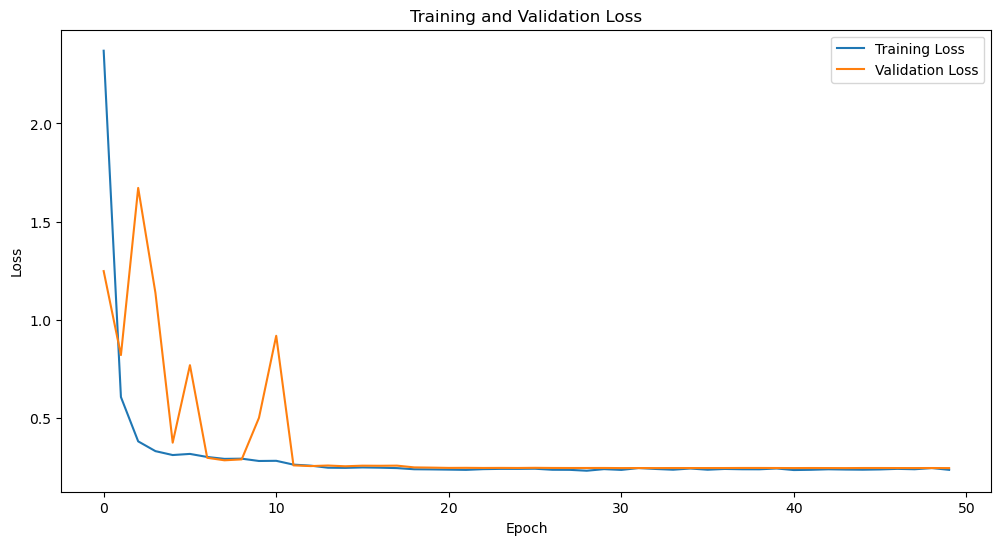

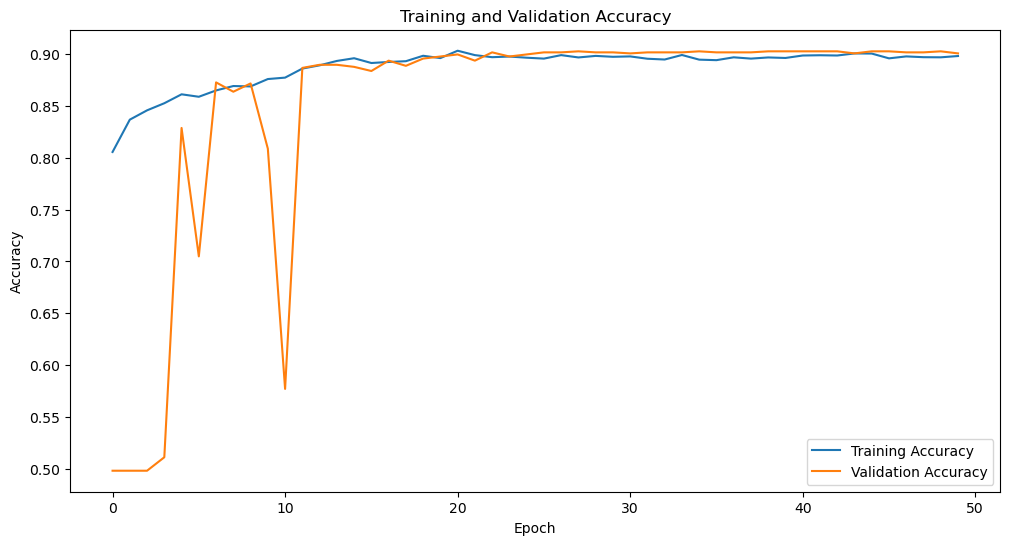

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取保存的训练历史数据
history_df = pd.read_csv(history_path)

# 可视化损失值
plt.figure(figsize=(12, 6))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 可视化准确率
plt.figure(figsize=(12, 6))
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取训练日志文件
log_file_path = history_path  # 替换为您的实际日志文件路径
log_data = pd.read_csv(log_file_path)

# 提取训练和验证的损失和准确率
loss = log_data['loss']
accuracy = log_data['accuracy']
val_loss = log_data['val_loss']
val_accuracy = log_data['val_accuracy']

# 获取最后一个epoch的指标
# last_epoch = log_data['epoch'].iloc[-1]
last_loss = log_data['loss'].iloc[-1]
last_accuracy = log_data['accuracy'].iloc[-1]
last_val_loss = log_data['val_loss'].iloc[-1]
last_val_accuracy = log_data['val_accuracy'].iloc[-1]

# 打印最后一个epoch的指标
# print(f"Last Epoch: {last_epoch}")
print(f"Last Train Loss: {last_loss}")
print(f"Last Train Accuracy: {last_accuracy}")
print(f"Last Validation Loss: {last_val_loss}")
print(f"Last Validation Accuracy: {last_val_accuracy}")




Last Train Loss: 0.2335742563009262
Last Train Accuracy: 0.8977711200714111
Last Validation Loss: 0.2425349503755569
Last Validation Accuracy: 0.9002991318702698


# **Evaluate and Visualize Loss, Accuracy, ROC-AUC, Precision, PRC, F1-score, Recall, Sensitivity, Specificity, Confusion Matrix.**

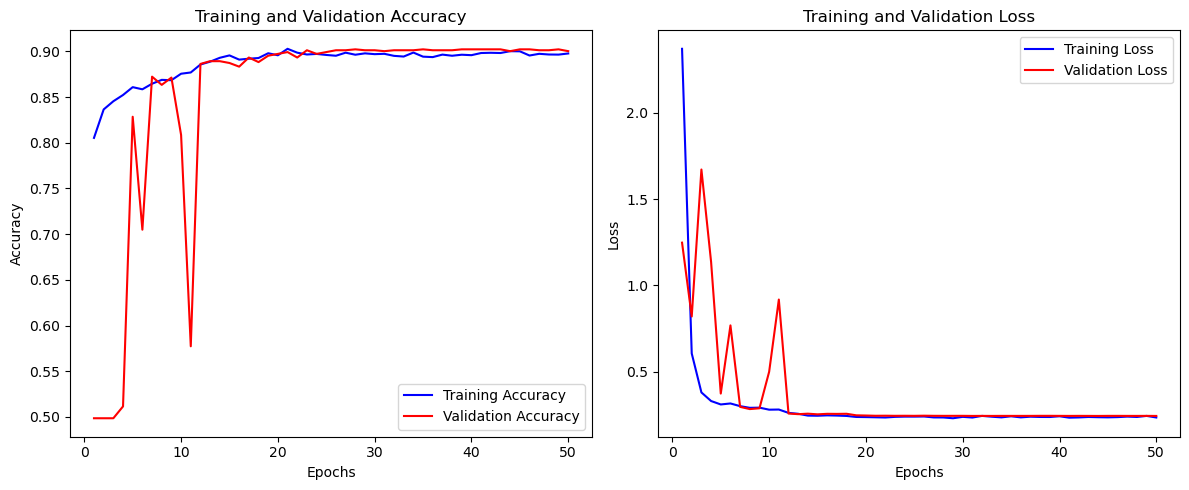

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot the training and validation accuracy and loss.

    Parameters:
    history: A Keras History object containing the training and validation loss and accuracy for each epoch.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 使用示例
plot_training_history(history1)


In [12]:
loaded_model = load_model(checkpoint_path)

evaluation_result = loaded_model.evaluate(test_generator, steps=16)

16/16 [==============================] - 2s 95ms/step - loss: 0.2607 - accuracy: 0.8897 - precision: 0.8897 - recall: 0.8897


30/30 [==============================] - 2s 38ms/step


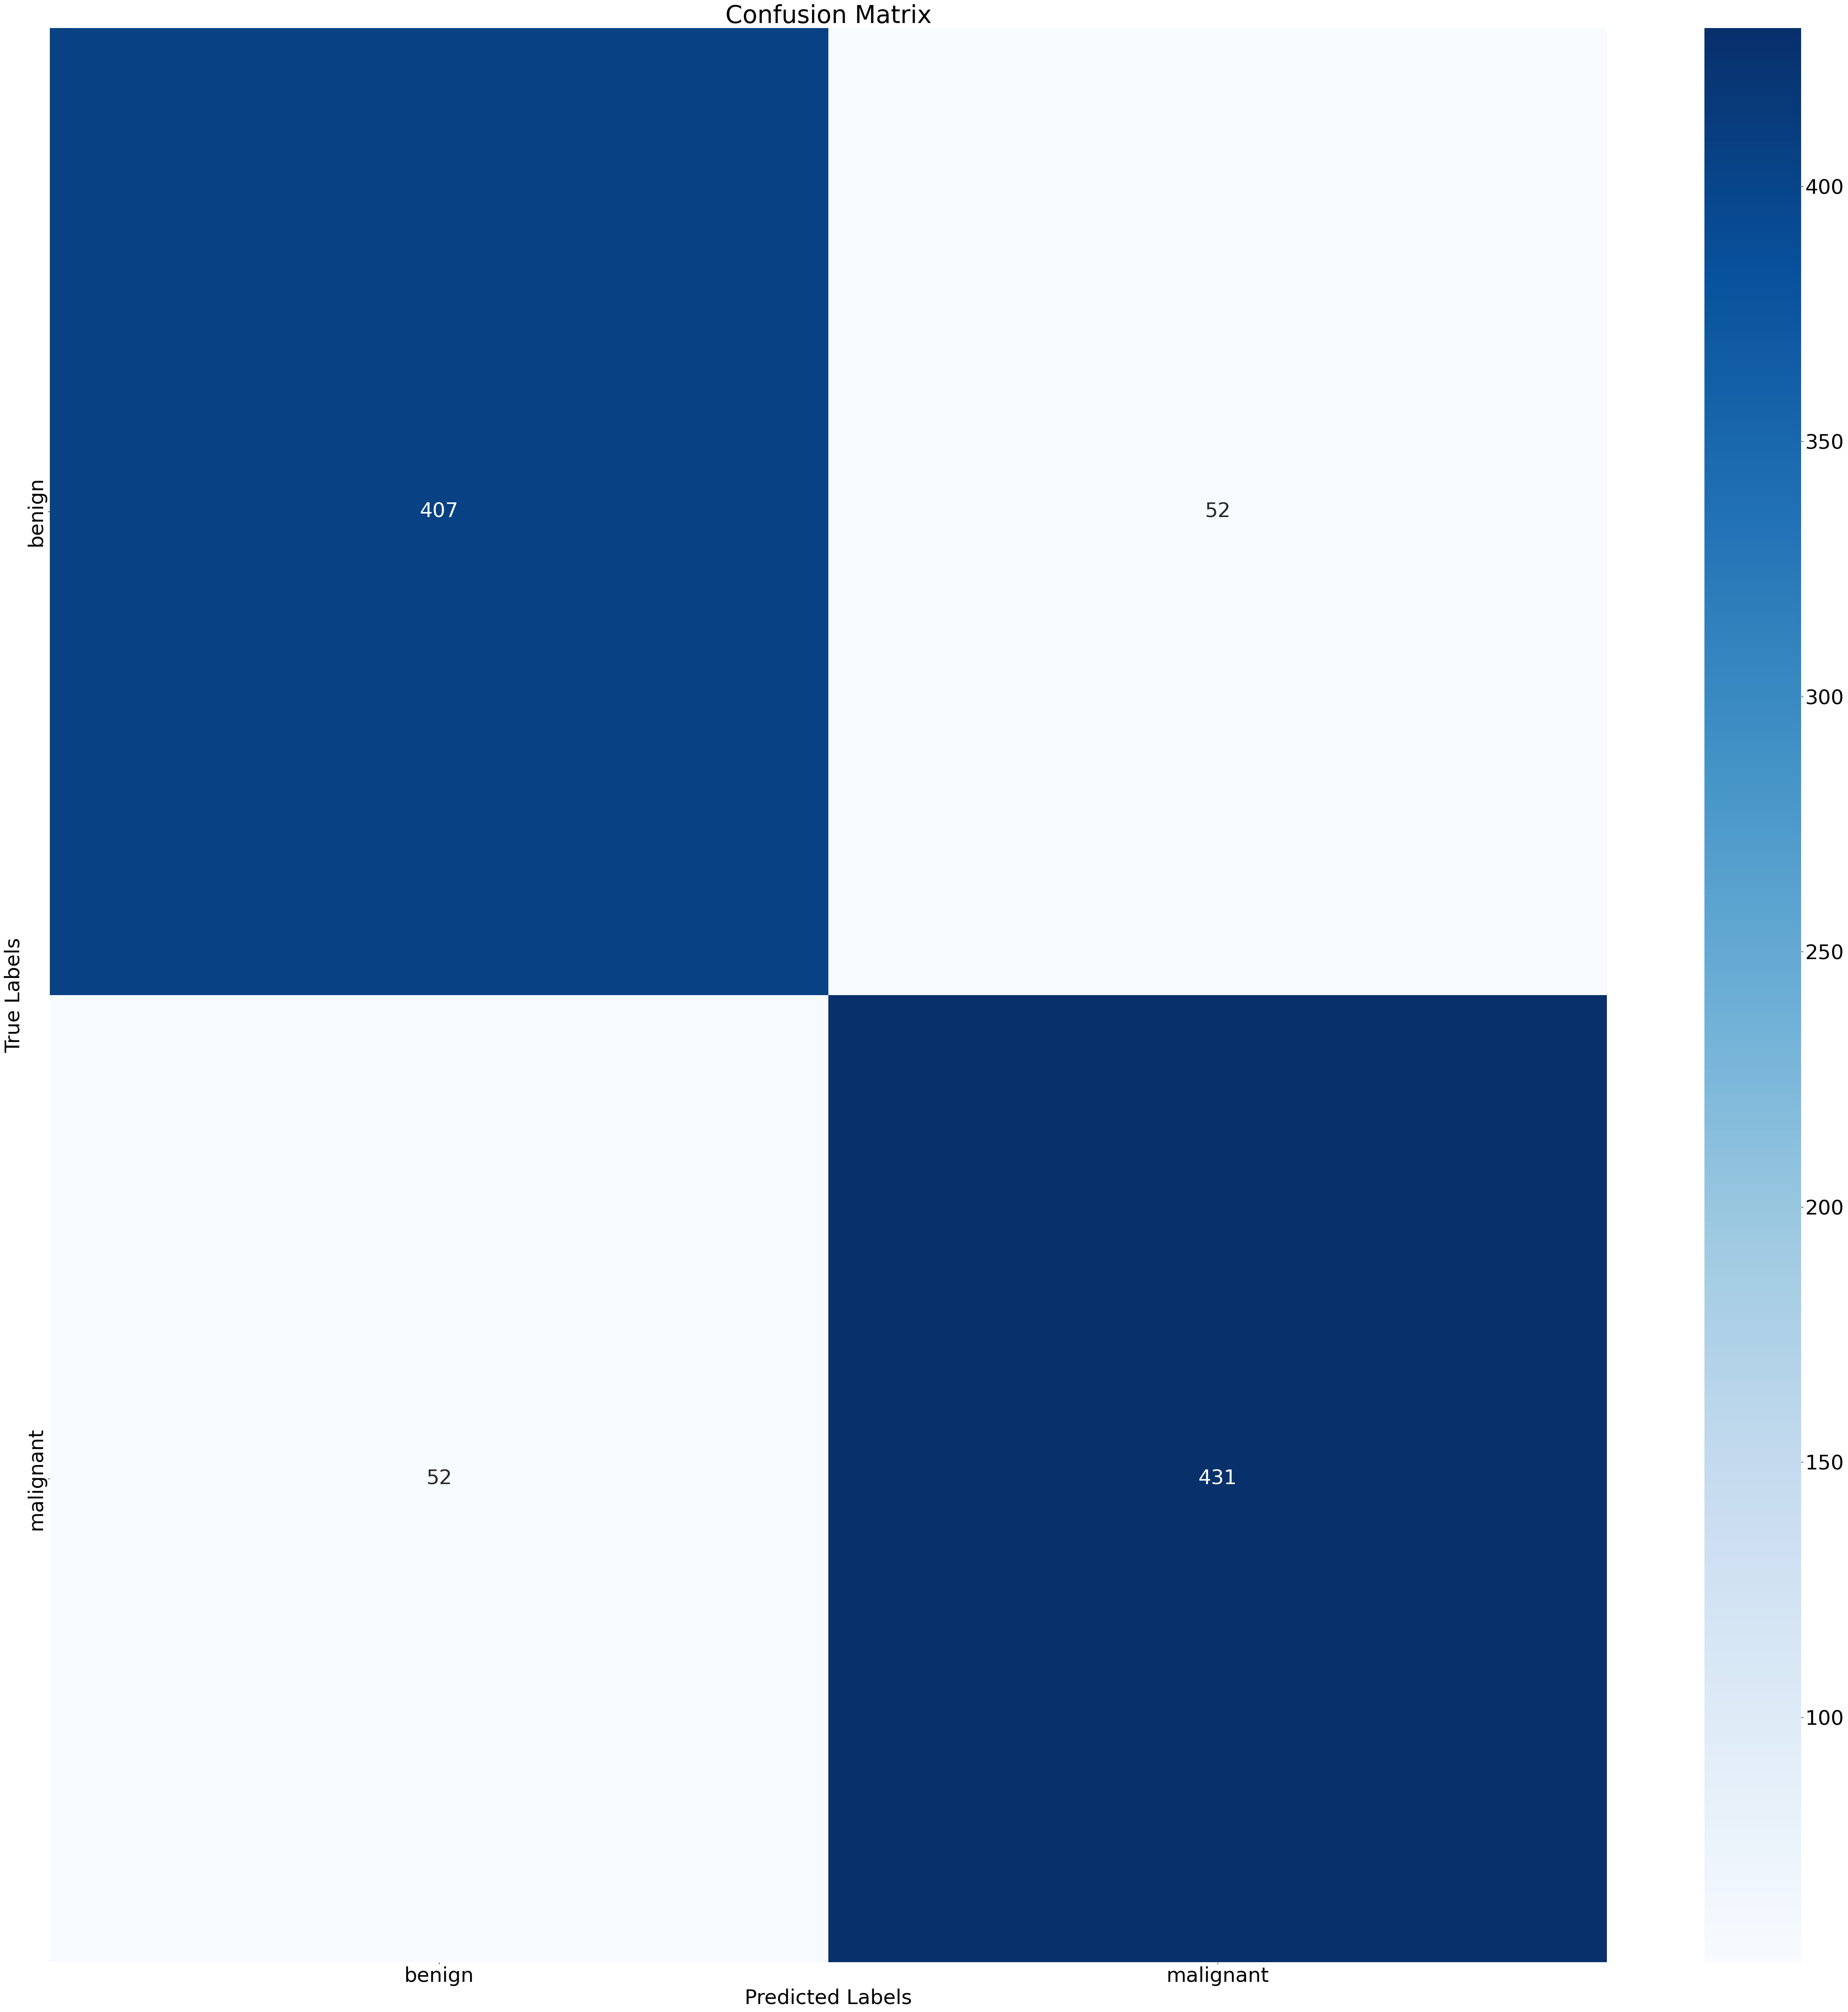

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# loaded_model = load_model('modelPerformance3\checkpoints\model_checkpoint3.h5')

all_images = []
all_true_labels = []

for _ in range(test_generator.samples // test_generator.batch_size):
    images, true_labels = next(test_generator)
    all_images.extend(images)
    all_true_labels.extend(true_labels)

all_images = np.array(all_images)
all_true_labels = np.argmax(np.array(all_true_labels), axis=1)

predictions = loaded_model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(all_true_labels, predicted_labels)

plt.rc('font', size=35)
plt.figure(figsize=(60, 60))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


all_true_labels shape: (942, 2)
predictions shape: (942, 2)
30/30 [==============================] - 1s 36ms/step


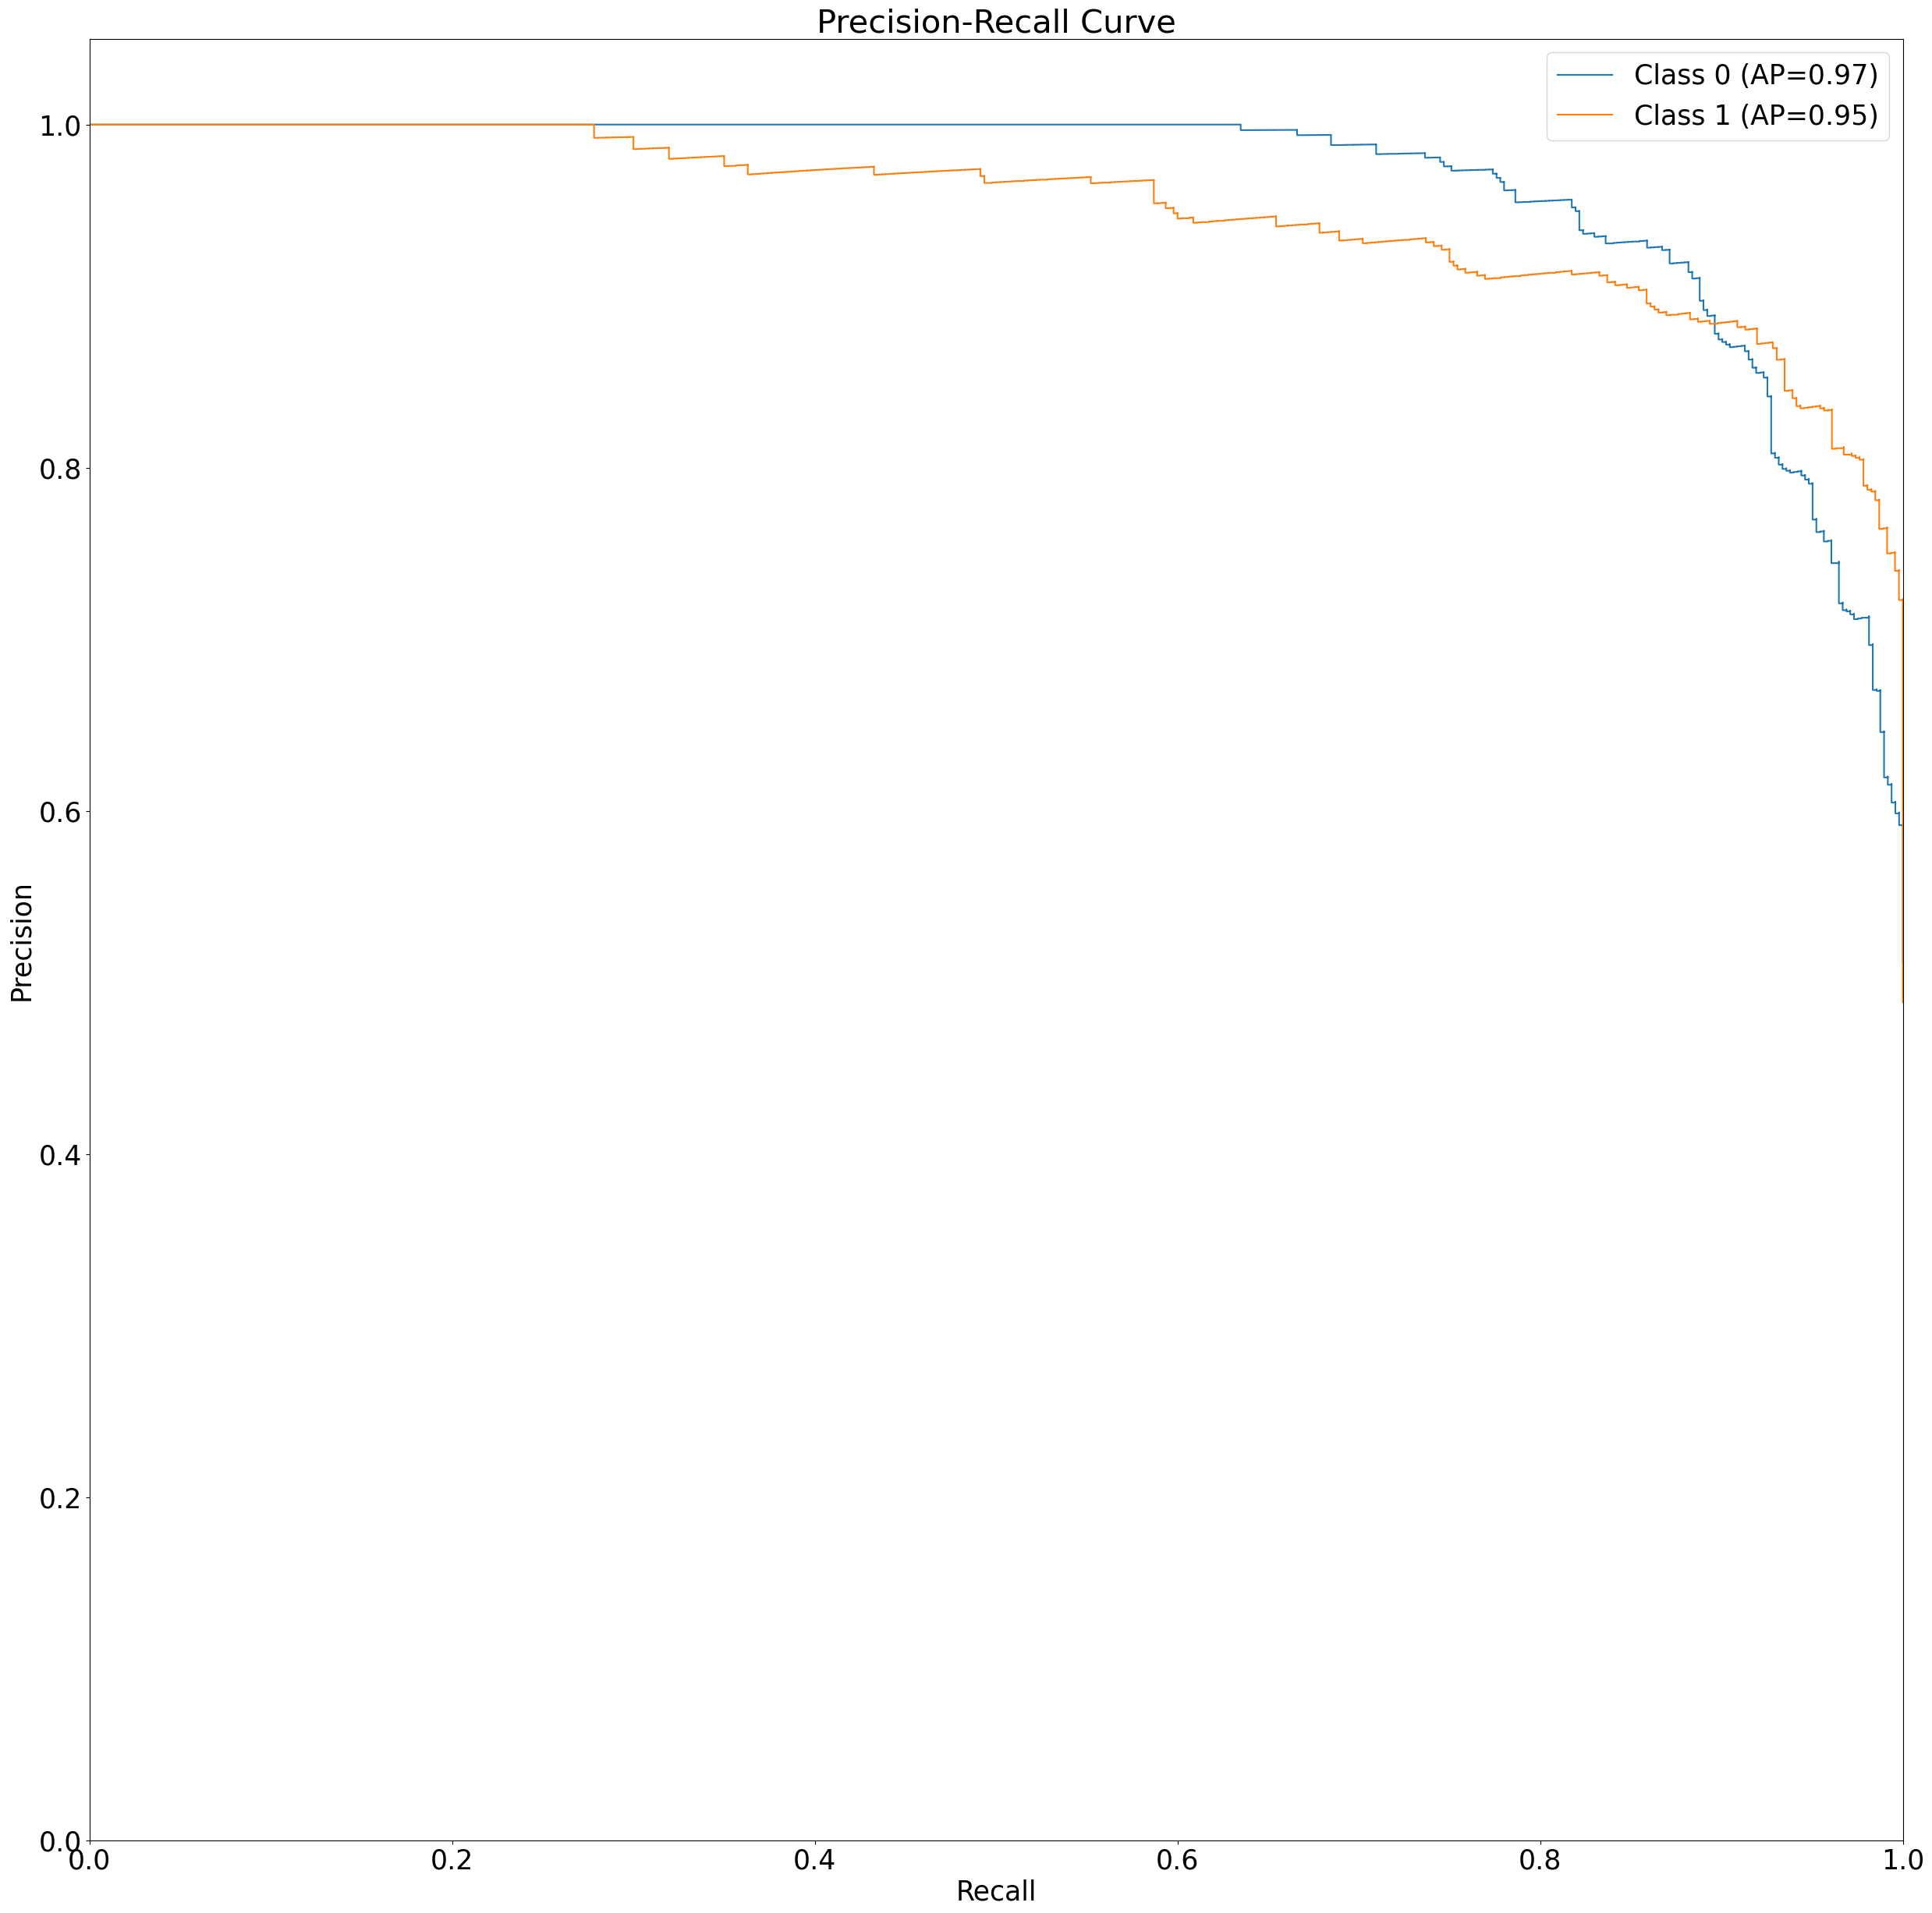

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

# 加载模型
# loaded_model = load_model('modelPerformance3\checkpoints\model_checkpoint3.h5')

# 获取所有图像和真实标签
all_images = []
all_true_labels = []


for _ in range(test_generator.samples // test_generator.batch_size):
    images, true_labels = next(test_generator)
    all_images.extend(images)
    all_true_labels.extend(true_labels)

all_images = np.array(all_images)
all_true_labels = label_binarize(np.argmax(np.array(all_true_labels), axis=1), classes=np.arange(class_count))  # num_classes 是你的类别数量

# 二分类的时候要加上这一行。
all_true_labels = np.column_stack((1 - all_true_labels, all_true_labels))


# Check the shape
print("all_true_labels shape:", all_true_labels.shape)
print("predictions shape:", predictions.shape)

# 进行预测
predictions = loaded_model.predict(all_images)

# 计算Precision-Recall曲线
precision = dict()
recall = dict()
average_precision = dict()


for i in range(class_count):
    precision[i], recall[i], _ = precision_recall_curve(all_true_labels[:, i], predictions[:, i])
    average_precision[i] = average_precision_score(all_true_labels[:, i], predictions[:, i])

# 绘制PR曲线
plt.rc('font', size=25)

plt.figure(figsize=(30, 30))

for i in range(class_count):
    plt.step(recall[i], precision[i], label=f'Class {i} (AP={average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()


30/30 [==============================] - 1s 35ms/step


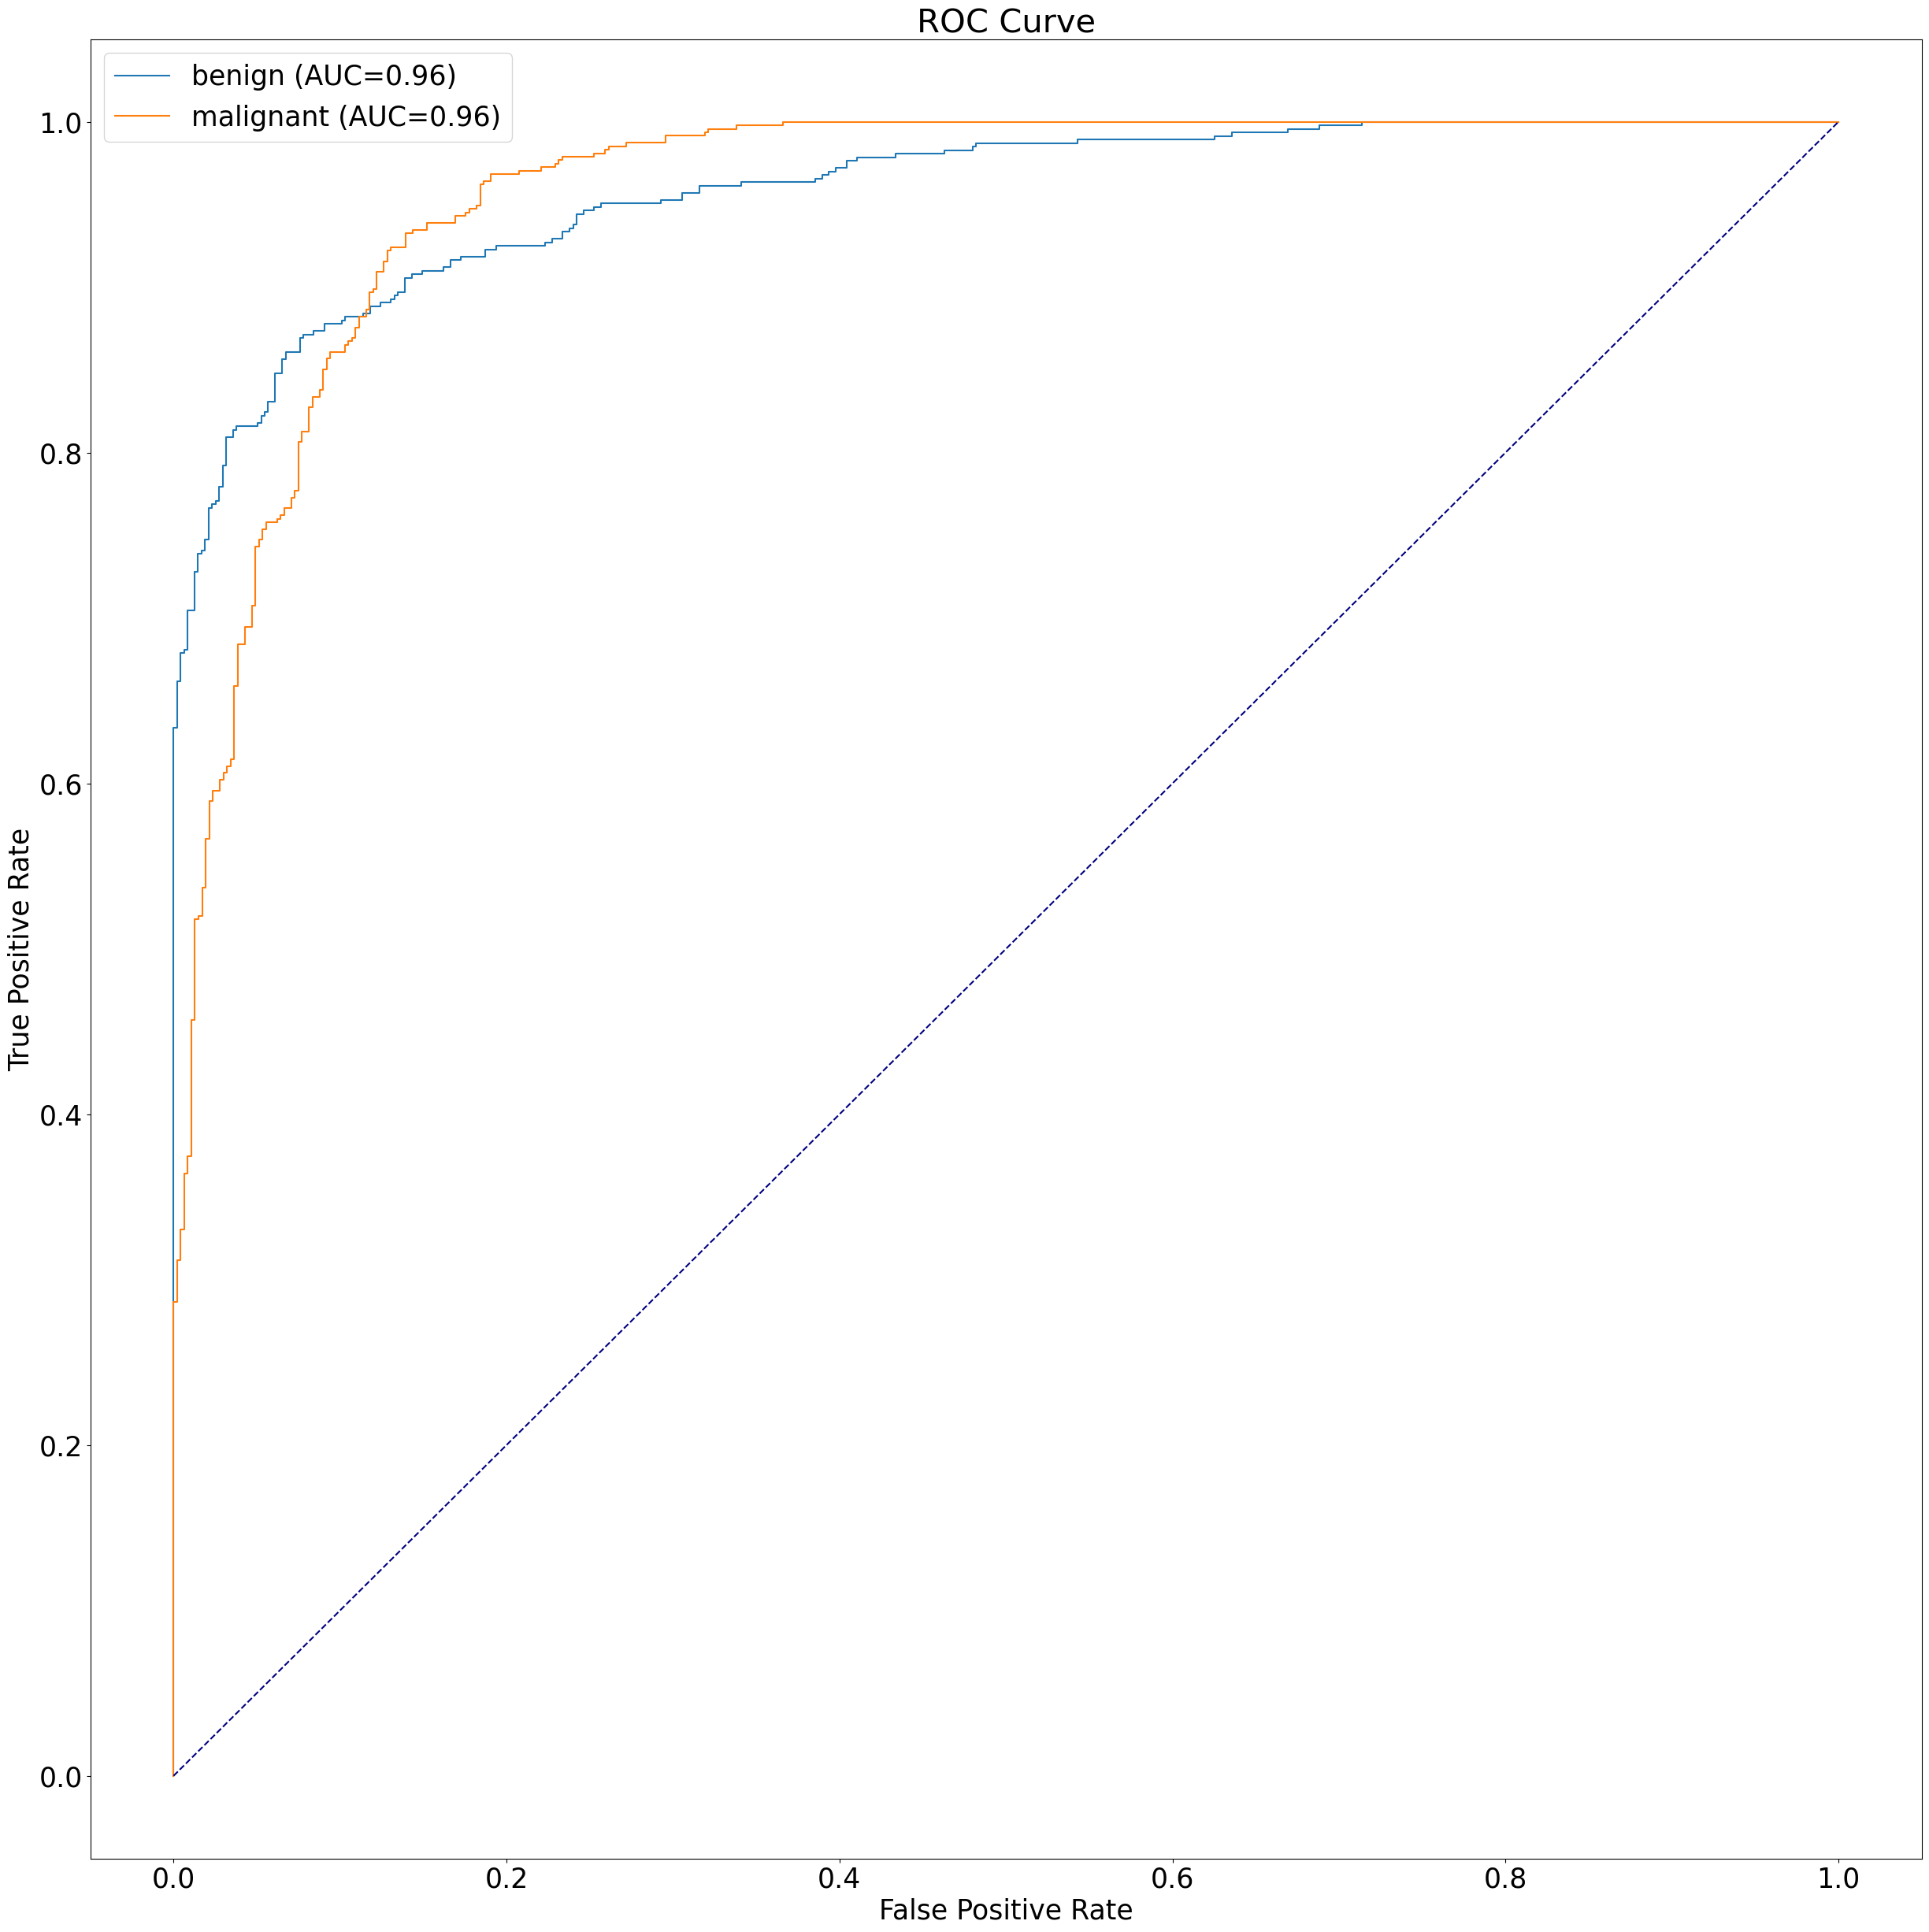

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model

# 加载模型
# loaded_model = load_model('modelPerformance3\checkpoints\model_checkpoint3.h5')

# 获取所有图像和真实标签
all_images = []
all_true_labels = []

for _ in range(test_generator.samples // test_generator.batch_size):
    images, true_labels = next(test_generator)
    all_images.extend(images)
    all_true_labels.extend(true_labels)

all_images = np.array(all_images)
class_names = test_generator.class_indices  # 获取类别名称到索引的映射
all_true_labels = label_binarize(np.argmax(np.array(all_true_labels), axis=1), classes=np.arange(len(class_names)))
all_true_labels = np.column_stack((1 - all_true_labels, all_true_labels))


# 进行预测
predictions = loaded_model.predict(all_images)

# 计算ROC曲线和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, class_name in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve(all_true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.rc('font', size=25)

plt.figure(figsize=(30, 30))

for i, class_name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC={roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()


30/30 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

      benign       0.89      0.89      0.89       474
   malignant       0.89      0.90      0.89       486

    accuracy                           0.89       960
   macro avg       0.89      0.89      0.89       960
weighted avg       0.89      0.89      0.89       960



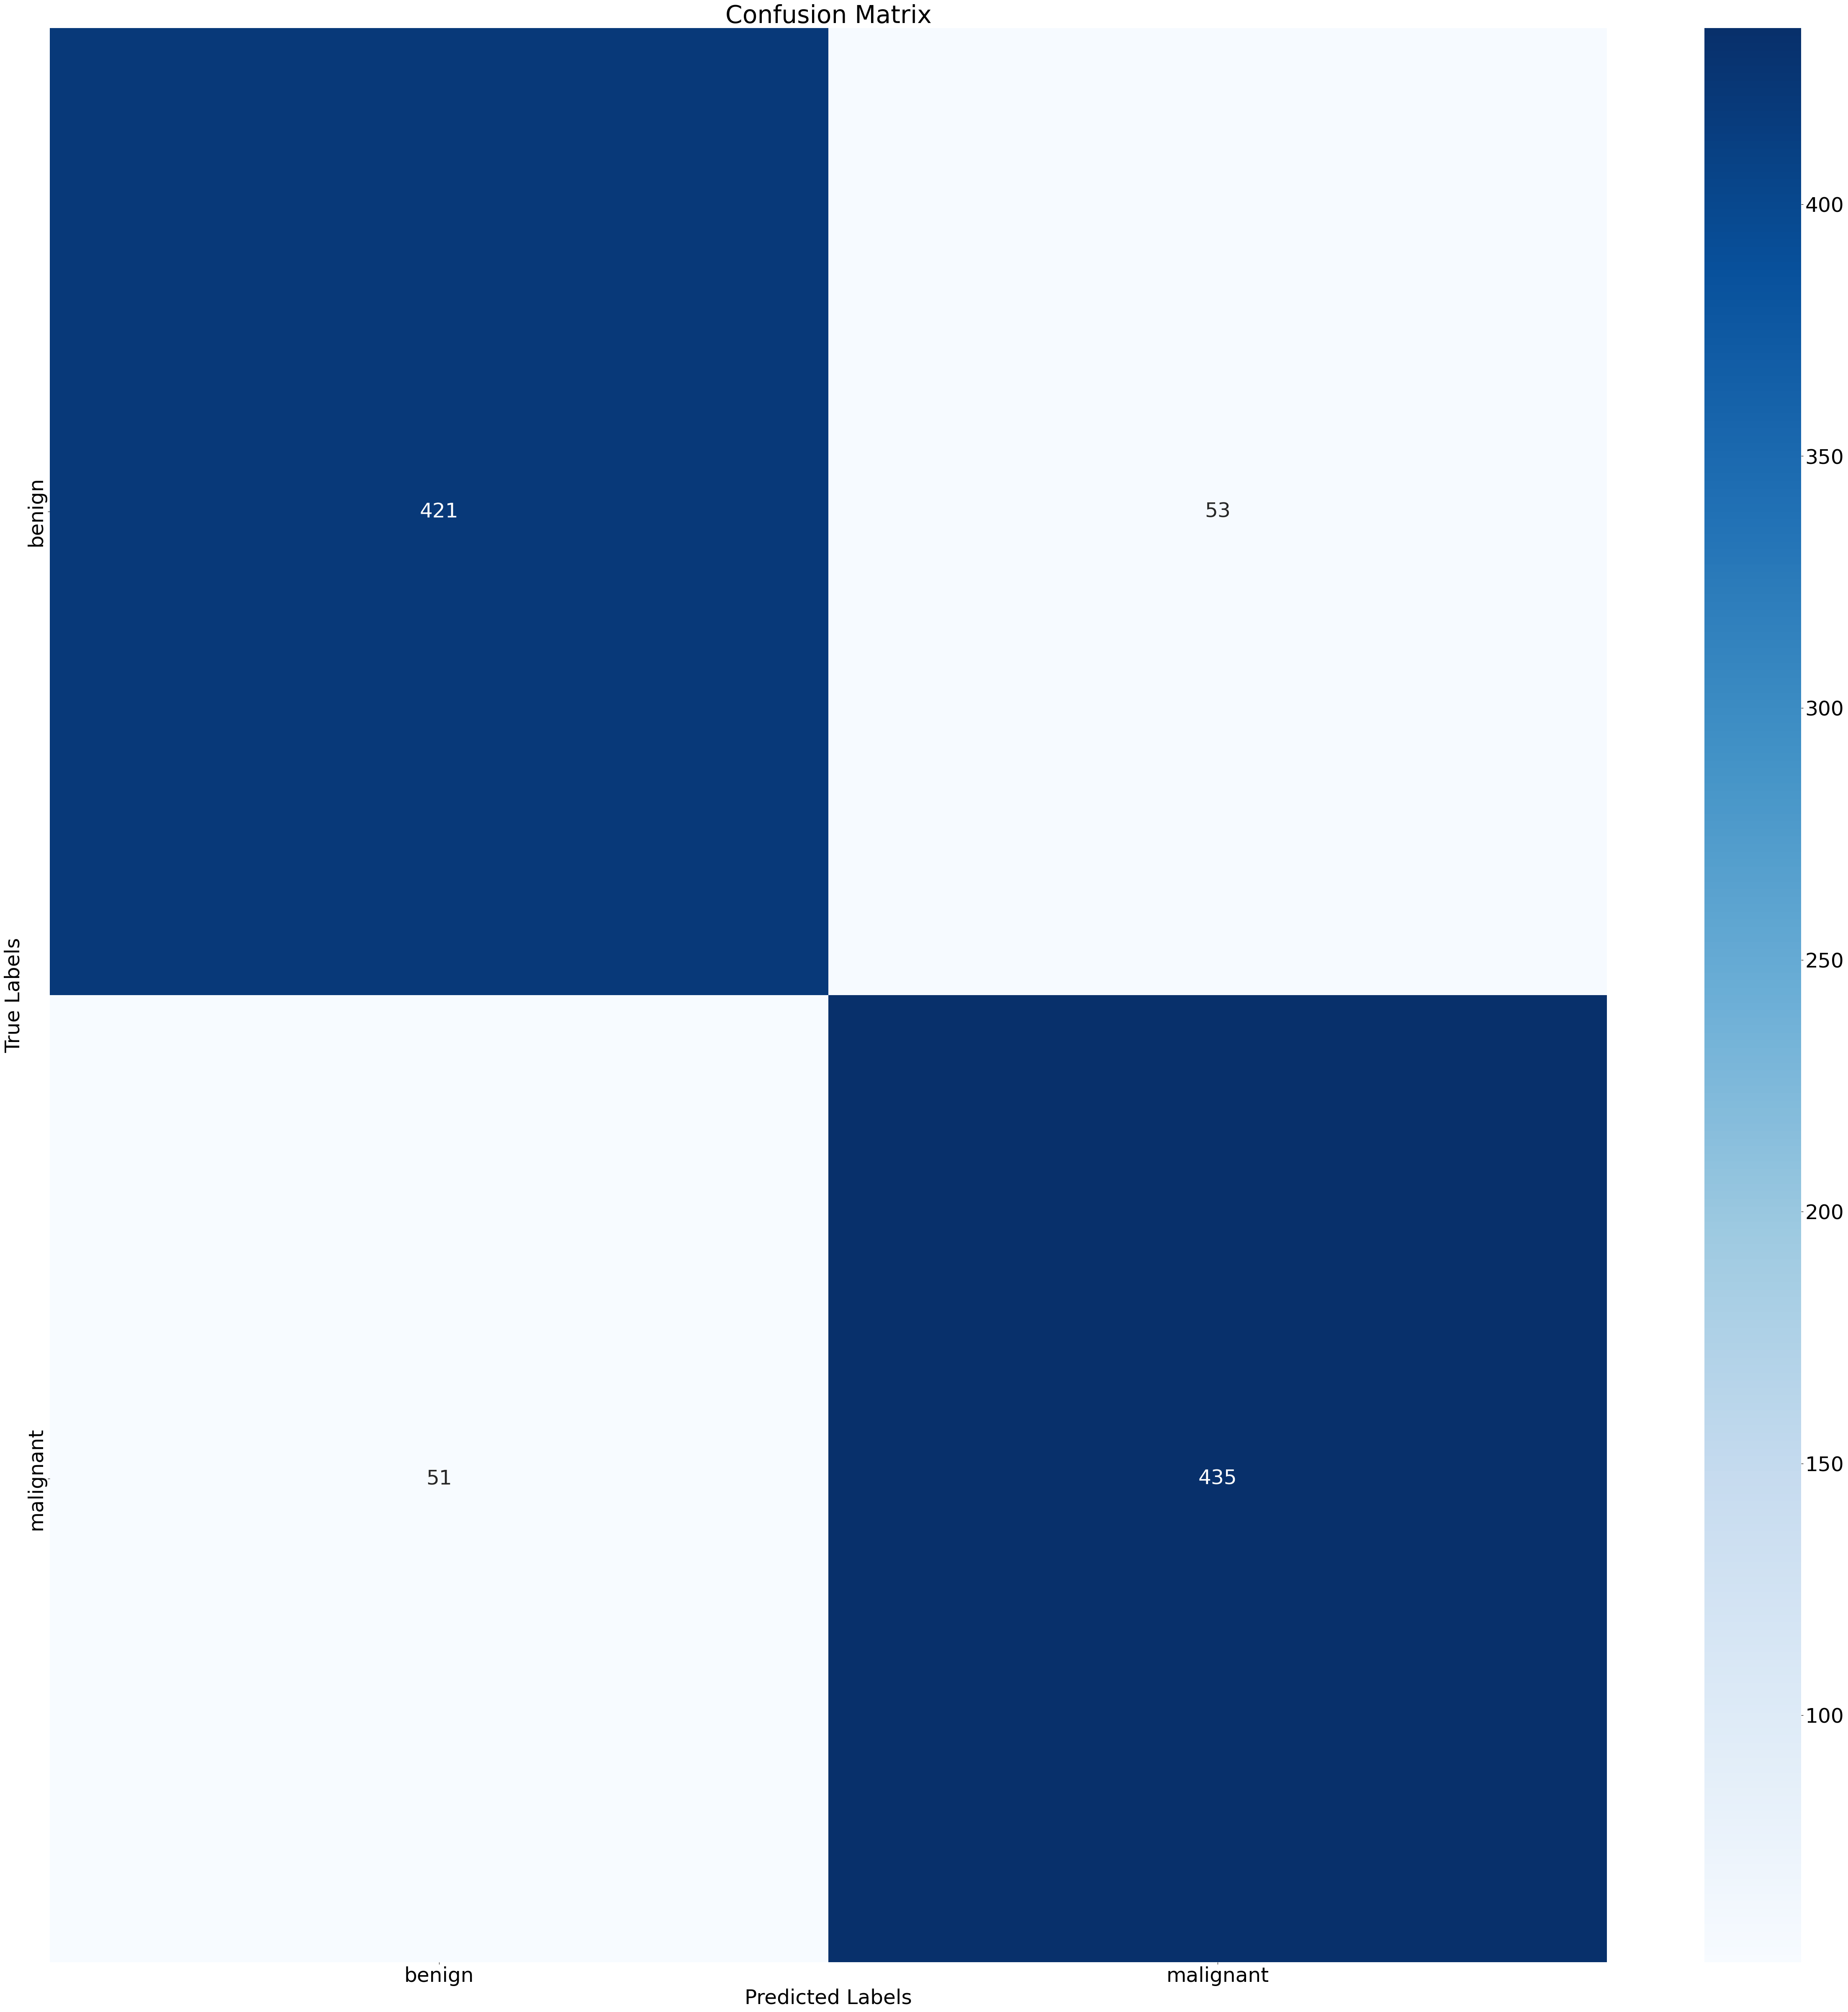

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# loaded_model = load_model('modelPerformance3\checkpoints\model_checkpoint3.h5')

all_images = []
all_true_labels = []

for _ in range(test_generator.samples // test_generator.batch_size):
    images, true_labels = next(test_generator)
    all_images.extend(images)
    all_true_labels.extend(true_labels)

all_images = np.array(all_images)
all_true_labels = np.argmax(np.array(all_true_labels), axis=1)


predictions = loaded_model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

# Generate Classification Report
class_names = test_generator.class_indices  # 获取类别名称到索引的映射
report = classification_report(all_true_labels, predicted_labels, target_names=class_names)

# Print Classification Report
print(report)

# Plot Confusion Matrix
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)

plt.rc('font', size=35)
plt.figure(figsize=(60, 60))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [17]:
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

# loaded_model = load_model('modelPerformance3\checkpoints\model_checkpoint3.h5')

all_images = []
all_true_labels = []

for _ in range(test_generator.samples // test_generator.batch_size):
    images, true_labels = next(test_generator)
    all_images.extend(images)
    all_true_labels.extend(true_labels)

all_images = np.array(all_images)
all_true_labels = np.argmax(np.array(all_true_labels), axis=1)

predictions = loaded_model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

# Generate F1 Score Report
class_names = test_generator.class_indices  # 获取类别名称到索引的映射
report = classification_report(all_true_labels, predicted_labels, target_names=class_names, output_dict=True)
f1_scores = {class_name: report[class_name]['f1-score'] for class_name in class_names}

# Print F1 Score Report
for class_name, f1_score in f1_scores.items():
    print(f"F1 Score for {class_name}: {f1_score}")


30/30 [==============================] - 1s 35ms/step
F1 Score for benign: 0.8865323435843055
F1 Score for malignant: 0.8862911795961743


In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def calculate_sensitivity_specificity(conf_matrix):
    # Calculate Sensitivity and Specificity for each class
    sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    specificity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    return sensitivity, specificity

# loaded_model = load_model('modelPerformance3\checkpoints\model_checkpoint3.h5')

all_images = []
all_true_labels = []

for _ in range(test_generator.samples // test_generator.batch_size):
    images, true_labels = next(test_generator)
    all_images.extend(images)
    all_true_labels.extend(true_labels)

all_images = np.array(all_images)
all_true_labels = np.argmax(np.array(all_true_labels), axis=1)

predictions = loaded_model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)

# Calculate Sensitivity and Specificity for each class
sensitivity, specificity = calculate_sensitivity_specificity(conf_matrix)

# Print Sensitivity and Specificity for each class
class_names = test_generator.class_indices  # 获取类别名称到索引的映射
for i, class_name in enumerate(class_names):
    print(f"{class_name} - Sensitivity: {sensitivity[i]}, Specificity: {specificity[i]}")


30/30 [==============================] - 1s 35ms/step
benign - Sensitivity: 0.888421052631579, Specificity: 0.9036402569593148
malignant - Sensitivity: 0.9036402569593148, Specificity: 0.888421052631579
